# Regresion Lineal

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Regresion Lineal Simple

Comenzaremos con la regresión lineal más familiar, un ajuste de línea recta a los datos.
Un ajuste en línea recta es un modelo de la forma
$$
y = ax + b
$$
donde $a$ se conoce comúnmente como *pendiente*, y $b$ se conoce comúnmente como *intersección*.

Considere los siguientes datos, que se encuentran dispersos sobre una línea con una pendiente de 2 y una intersección de -5:

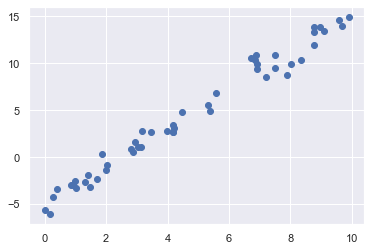

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Usaremos el estimador de Scikit-Learn ``LinearRegression`` para ajustar la data y construir el modelo:

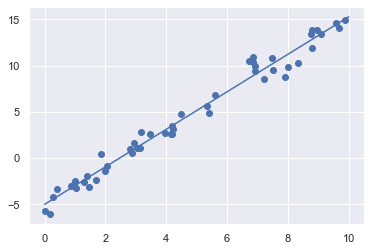

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

La pendiente y la intersección de los datos están contenidos en los parámetros de ajuste del modelo, que en Scikit-Learn siempre están marcados con un guión bajo al final.
Aquí los parámetros relevantes son `` coef_`` e `` intercept_``:

In [6]:
print("Pendiente:    ", model.coef_[0])
print("Intercepto:", model.intercept_)

Pendiente:     2.027208810360695
Intercepto: -4.998577085553202


Vemos que los resultados están muy cerca de las entradas, como podríamos esperar.

Sin embargo, el estimador de ``LinearRegression`` es mucho más capaz que esto; además de ajustes simples en línea recta, también puede manejar modelos lineales multidimensionales de la forma
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
donde hay multiples valores $x$.
Geométricamente, esto es similar a ajustar un plano a puntos en tres dimensiones, o ajustar un hiperplano a puntos en dimensiones más altas.

La naturaleza multidimensional de tales regresiones las hace más difíciles de visualizar, pero podemos ver uno de estos ajustes en acción construyendo algunos datos de ejemplo, usando el operador de multiplicación de matrices de NumPy:

In [7]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])
print(X.shape)
print(y.shape)
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

(100, 3)
(100,)
0.5000000000000127
[ 1.5 -2.   1. ]


Aquí, los datos $ y $ se construyen a partir de tres valores $ x $ aleatorios, y la regresión lineal recupera los coeficientes utilizados para construir los datos.

De esta manera, podemos usar el estimador único de ``LinearRegression``  para ajustar líneas, planos o hiperplanos a nuestros datos.
Todavía parece que este enfoque se limitaría a relaciones estrictamente lineales entre variables, pero resulta que también podemos relajar esto.

## Regresion de funciones base

Un truco que puede utilizar para adaptar la regresión lineal a relaciones no lineales entre variables es transformar los datos de acuerdo con *funciones base*.

La idea es tomar nuestro modelo lineal multidimensional:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
y construir $x_1, x_2, x_3,$, de nuestra entrada unidimiensional $x$.
Esto es, $x_n = f_n(x)$, donde $f_n()$ es una funcion que transforma la data.

Por ejemplo, si $f_n(x) = x^n$, nuestro modelo se transforma en una regresion polinomial:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Observe que este es *todavía un modelo lineal*: la linealidad se refiere al hecho de que los coeficientes $a_n$ nunca se multiplican ni se dividen entre sí.
Lo que hemos hecho efectivamente es tomar nuestros valores unidimensionales $x$ y proyectarlos en una dimensión superior, de modo que un ajuste lineal pueda encajar relaciones más complicadas entre $x$ y $y$.

### Funciones de base polinomial

Esta proyección polinomial es lo suficientemente útil como para estar integrada en Scikit-Learn, utilizando el transformador ``PolynomialFeatures``:

In [59]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

Vemos aquí que el transformador ha convertido nuestra matriz unidimensional en una matriz tridimensional tomando el exponente de cada valor.
Esta nueva representación de datos de mayor dimensión se puede conectar a una regresión lineal.


In [60]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

Con esta transformación en su lugar, podemos usar el modelo lineal para ajustar relaciones mucho más complicadas entre $x$ y $y$.
Por ejemplo, aquí hay una onda sinusoidal con ruido:

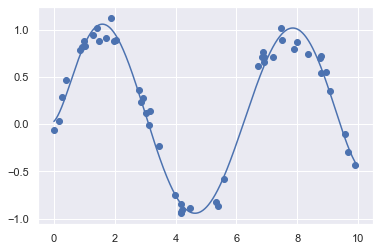

In [61]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Nuestro modelo lineal, mediante el uso de funciones de base polinomial de séptimo orden, puede proporcionar un ajuste excelente a estos datos no lineales.

### Funciones base gaussianas
Por supuesto, son posibles otras funciones básicas.
Por ejemplo, un patrón útil es ajustar un modelo que no es una suma de bases polinomiales, sino una suma de bases gaussianas.
El resultado podría parecerse a la siguiente figura:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.06-gaussian-basis.png?raw=1)
[figure source in Appendix](#Gaussian-Basis)

Las regiones sombreadas en el gráfico son las funciones base escaladas y, cuando se suman, reproducen la curva suave a través de los datos.
Estas funciones de base gaussiana no están integradas en Scikit-Learn, pero podemos escribir un transformador personalizado que las creará, como se muestra aquí y se ilustra en la siguiente figura (los transformadores de Scikit-Learn se implementan como clases de Python; leer la fuente de Scikit-Learn es una buena forma de ver cómo se pueden crear):

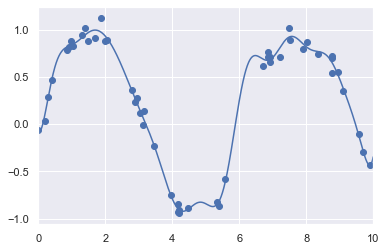

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

Ponemos este ejemplo aquí solo para aclarar que no hay nada mágico en las funciones de base polinómica: si tiene algún tipo de intuición en el proceso de generación de sus datos que le hace pensar que una base u otra podría ser apropiada, puede usarlas como bien.

## Regularization

La introducción de funciones base en nuestra regresión lineal hace que el modelo sea mucho más flexible, pero también puede conducir muy rápidamente a un ajuste excesivo.
Por ejemplo, si elegimos demasiadas funciones de base gaussiana, terminamos con resultados que no se ven tan bien:

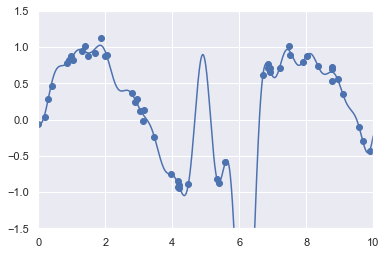

In [63]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

Con los datos proyectados a la base de 30 dimensiones, el modelo tiene demasiada flexibilidad y llega a valores extremos entre ubicaciones donde está limitado por los datos.
Podemos ver la razón de esto si graficamos los coeficientes de las bases gaussianas con respecto a sus ubicaciones:

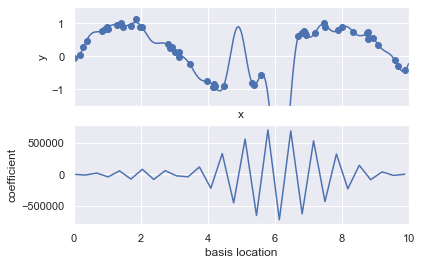

In [64]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

El panel inferior de esta figura muestra la amplitud de la función base en cada ubicación.
Este es un comportamiento de sobreajuste típico cuando las funciones base se superponen: los coeficientes de las funciones base adyacentes explotan y se cancelan entre sí.
Sabemos que tal comportamiento es problemático, y sería bueno si pudiéramos limitar explícitamente tales picos en el modelo penalizando los valores grandes de los parámetros del modelo.
Esta penalización se conoce como *regularización* y se presenta en varias formas.

### Ridge regression ($L_2$ Regularization)

Quizás la forma más común de regularización se conoce como *ridge regression* o $ L_2 $ *regularización*, a veces también llamada *regularización de Tikhonov*.
Esto procede penalizando la suma de cuadrados (2-normas) de los coeficientes del modelo; en este caso, la penalización en el ajuste del modelo sería
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
donde $\alpha$ es un parametro libre que controla la fuerza de la penalidad.


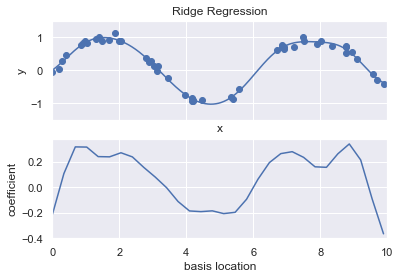

In [65]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

El parámetro $\alpha$ es esencialmente una perilla que controla la complejidad del modelo resultante.
En el límite $\alpha\ \to 0$, recuperamos el resultado de regresión lineal estándar; en el límite $\alpha \to \infty$, se suprimirán todas las respuestas del modelo.
Una ventaja de la regresión de crestas en particular es que se puede calcular de manera muy eficiente, a un costo computacional apenas mayor que el modelo de regresión lineal original.

### Lasso regression ($L_1$ regularization)

Otro tipo de regularización muy común se conoce como Lasso, e implica penalizar la suma de valores absolutos (1-norma) de los coeficientes de regresión:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Aunque esto es conceptualmente muy similar a la regresión de crestas, los resultados pueden diferir sorprendentemente: por ejemplo, debido a razones geométricas, la regresión de lazo tiende a favorecer *modelos dispersos* cuando es posible: es decir, preferentemente establece los coeficientes del modelo exactamente a cero.

Podemos ver este comportamiento al duplicar la figura de regresión de la cresta, pero usando coeficientes normalizados L1:

C:\Users\hector\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870486668, tolerance: 0.002065280097246271
  positive)


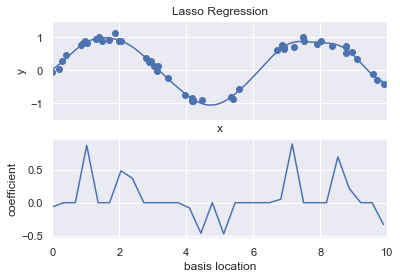

In [66]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

Con la penalización por regresión de lazo, la mayoría de los coeficientes son exactamente cero, y el comportamiento funcional está modelado por un pequeño subconjunto de las funciones básicas disponibles.
Al igual que con la regularización de crestas, el parámetro $\alpha$ ajusta la fuerza de la penalización y debe determinarse mediante, por ejemplo, validación cruzada.

# Otro Ejemplo

In [8]:
# Manera convencional para incluir la libreria
import pandas as pd


In [9]:
#Lee un archivo CSV directamente de una URL y guarda los resultados
data = pd.read_csv('https://raw.githubusercontent.com/buruzaemon/me-ml/master/ISLR/Data/Advertising.csv', index_col=0)
# Muestra las 5 primeras filas
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Tipos de objetos principales:

- **DataFrame:** filas y columnas (Como una planilla de cálculo)
- **Series:** una sola columna

In [10]:
# Muestra las 5 últimas filas
data.tail()

,TV,Radio,Newspaper,Sales
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4


In [11]:
# Para chequear la forma de la matriz
data.shape

(200, 4)

¿Cuáles son las características?

- **TV:** miles de dolares gastados en publicidad por TV por un producto.
- **Radio:** miles de dolares gastados en Radio
- **Newspaper:** miles de dolares gastados en Diarios escritos

¿Cuál es la variable respuesta?
- **Sales:** ventas del producto (miles)

¿Qué más sabemos?
- Debido a que la variable respuesta es contínua, es un problema de regresión.
- Hay 200 observaciones (filas), y cada una es un mercado único.

## Visualizando la data usando seaborn

**Seaborn:** Libreria de visualización de datos construida sobre Matplotlib

- Anaconda: ejecutar **`conda install seaborn`** en una ventana de comando
- Otros usuario: [installation instructions](http://stanford.edu/~mwaskom/software/seaborn/installing.html)

In [12]:
# Manera convencional de importar seaborn
import seaborn as sns

# Permitir que los graficos aparezcan en las celdas
%matplotlib inline

C:\Users\hector\anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


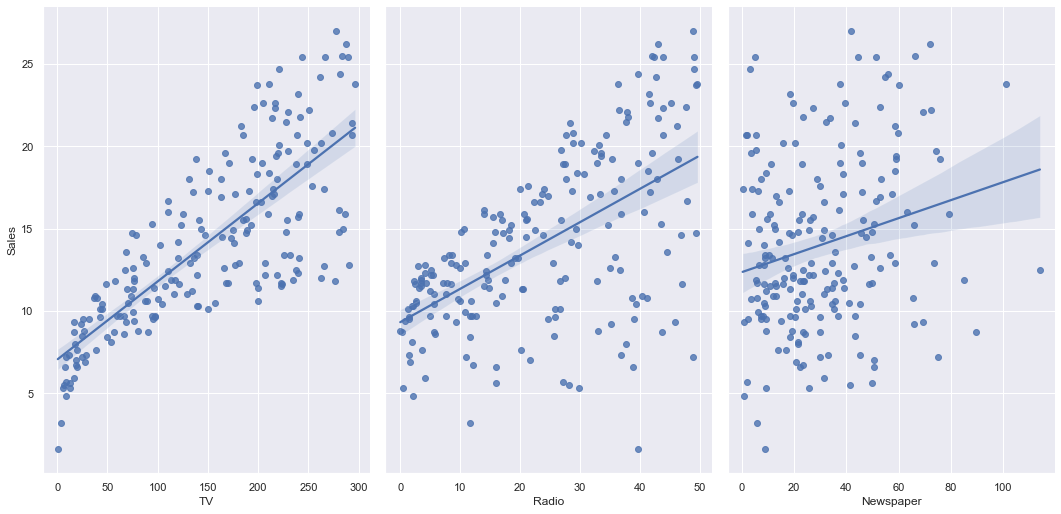

In [13]:
# Visualizar la relación entre las caracteristitas y la respuesta usando scatterplots
sns.pairplot(data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=7, aspect=0.7, kind='reg')

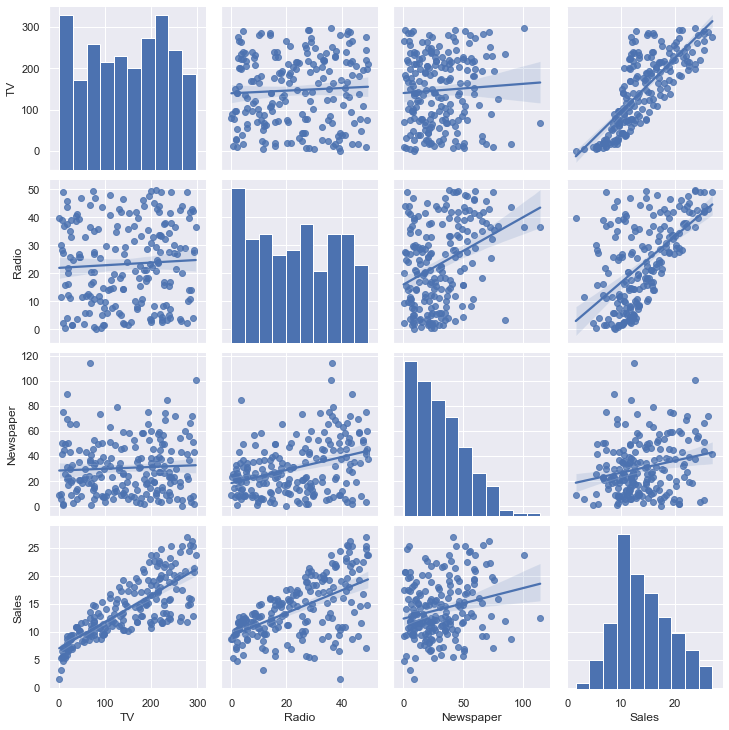

In [14]:
sns.pairplot(data, kind="reg")

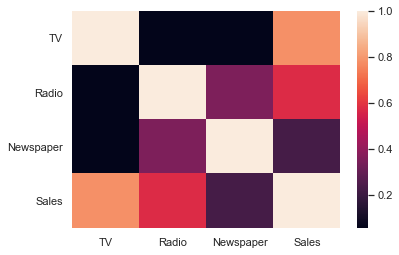

In [15]:
corr=data.corr()
ax = sns.heatmap(corr)

In [16]:
corr

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


## Regresión lineal

**Ventajas:** Rápido, no requiere ajustes, altamente interpretable, fácil de entender

**Desventajas:** Muy difíl de que se obtenga un buen desempeño predictivo (presume una relación lineal entre cada una de las caracteristicas y la respuesta.)

### Forma de la regresión lineal

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ es la respuesta
- $\beta_0$ es el intercepto
- $\beta_1$ es el coeficiente para $x_1$ (primera característica)
- $\beta_n$ es el coeficiente para $x_n$ (caracteristica n-esima)

En este caso en particular:

$y = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio + \beta_3 \times Newspaper$

Los valores $\beta$ son llamados **coeficientes del modelo**. Estos valores se "aprenden" durante el paso de ajuste del modelo utilizando el criterio "mínimos cuadrados". Después, el modelo "entrenado" se puede usar para hacer pronósticos.

## Preparando X e y usando pandas

- scikit-learn espera que X (matriz de caracteristicas) e y (vector de respuesta) sean arreglos Numpy.
- Sin embargo, pandas está construido sobre Numpy.
- Por lo tanto, X puede ser un DataFrame de pandas e y pandas Series.

In [17]:
columnas=list(data.columns.values)
print (columnas)

['TV', 'Radio', 'Newspaper', 'Sales']


In [18]:
# Crear una lista de Python con los nombre de las caracteristicas
feature_cols = ['TV', 'Radio', 'Newspaper']

# Use esta lista para seleccionar el subconjunto del DataFrame original
X = data[feature_cols]

# Comando equivalente para hacerlo en una linea
#X = data[['TV', 'radio', 'newspaper']]

# Tambien se puede usar la lista columnas
#X = data[columnas[:len(columnas)]]

# Imprime las 5 primeras filas
X.head()

,TV,Radio,Newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4


In [19]:
# Chequea el tipo y forma de X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(200, 3)


In [20]:
# Selecciona una "Serie" del DataFrame
y = data['Sales']

# Comando equivalente que funciona si no hay espacios en la columna nombre
#y = data.Sales

# Se puede usar tambien la ultima columna
#y = data[columnas[-1]]

# Imprime los 5 primeros valores
y.head()

1    22.1
2    10.4
3     9.3
4    18.5
5    12.9
Name: Sales, dtype: float64

In [21]:
# Chequea el tipo y forma de "y"
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(200,)


### Particionando X e y en conjuntos de entrenamiento y test

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [23]:
# Por defecto el particionamiento es 75% entrenamiento y 25% test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(150, 3)
(150,)
(50, 3)
(50,)


## Regresión lineal en scikit-learn

In [24]:
# importar el modelo
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Instanciarlo (alpha siempre debe ser un numero positivo)
linreg = LinearRegression()
ridge=Ridge(alpha=0.00001)
lasso = Lasso(alpha=0.00001)

# Ajustar el modelo a los datos de entrenamiento (aprender los coeficientes)
linreg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Interpretando los coeficientes del modelo

In [25]:
# Imprime el intercepto y los coeficientes de la Regresión lineal
print(linreg.intercept_)
print(linreg.coef_)

# Imprime el intercepto y los coeficientes de la Regresión Ridge
print(ridge.intercept_)
print(ridge.coef_)

# Imprime el intercepto y los coeficientes de la Regresión LASSO
print(lasso.intercept_)
print(lasso.coef_)

2.87696662231793
[0.04656457 0.17915812 0.00345046]
2.8769666232589834
[0.04656457 0.17915812 0.00345046]
2.8769678960751683
[0.04656457 0.17915809 0.00345045]


In [26]:
# "parea" los nombres con sus coeficientes
list(zip(feature_cols, linreg.coef_))

[('TV', 0.04656456787415028),
 ('Radio', 0.17915812245088839),
 ('Newspaper', 0.0034504647111804412)]

$$y = 2.88 + 0.0466 \times TV + 0.179 \times Radio + 0.00345 \times Newspaper$$

¿Cómo se interpreta el **coeficientes TV** (0.0466)?

- Para un monto dado de gasto de advertising de Radio y Newspaper, **una "unidad" de incremente en el gasto de advertising en TV** se asocia **0.0466 "unidades" de incremento en Ventas**.
- O más claramente: 
- Para un monto dado de gasto de advertising de Radio y Newspaper, **gastar 1000 adicionales en advertising en TV** se asocia con **un incremento de 46.6 unidades en ventas**.

Importante:
- No confundir **asociación** con **causalidad**. 
- Si un incremento en gastos de advertising se asocia con un **decremento** en ventas, $\beta_1$ sería negativo.

### Realizando predicciones

In [27]:
# Realizando predicciones con el conjunto de test
y_pred = linreg.predict(X_test)
y_pred2 = ridge.predict(X_test)
y_pred3 = lasso.predict(X_test)

¿Qué falta ahora? Revisar la **calidad** de ésta predicción.
Necesitamos una **métrica de desempeño** para comparar las predicciones con los valores reales!

## Métricas de evaluación de modelos para regresión

Las medidas de desempeño o evaluación para problemas de clasificación, tales como **accuracy** o **F1-score**, no sirven para problemas de regresión.
A continuación se presentan **tres metricas de evaluación**:

In [28]:
# Definir valores reales y predichos
true = [100, 50, 30, 20]
pred = [90, 50, 50, 30]

**Mean Absolute Error** (MAE) es la media de las diferencias absolutas entre el valor real y el predicho:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

In [29]:
# Calcular el MAE a mano
print(abs(10 + 0 + 20 + 10)/4.)

# Calcular MAE con scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(true, pred))

10.0
10.0


**Mean Squared Error** (MSE) es la media de los errores al cuadrado:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

In [30]:
# A mano
print((10**2 + 0**2 + 20**2 + 10**2)/4.)

# Con scikit-learn
print(metrics.mean_squared_error(true, pred))

150.0
150.0


**Root Mean Squared Error** (RMSE) la raíz de MSE:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [31]:
# A "mano"
import numpy as np
print(np.sqrt((10**2 + 0**2 + 20**2 + 10**2)/4.))

# Con scikit-learn
print(np.sqrt(metrics.mean_squared_error(true, pred)))

12.24744871391589
12.24744871391589


Comparación de estas métricas:

- **MAE** es el más fácil de entender, porque es el error promedio.
- **MSE** más popular que el anterior, porque penaliza los errores grandes.
- **RMSE** más interpretable que el anterior.

### Computar el RMSE para computar las predicciones de Ventas (primer ejemplo)

In [32]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

1.4046514230328957
1.4046514233548126
1.4046515196083609


## Mejores Parametros para LASSO (tambien aplicable a Ridge Regression)

In [33]:
mejor_resultado=float('Inf')

alpha_lasso = [1e-40,1e-35,1e-30, 1e-20, 1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10,100,1000,10000] 
for alpha in alpha_lasso:
    lasso = Lasso(alpha=alpha,normalize=True)
    lasso.fit(X_train, y_train)
    y_pred3 = lasso.predict(X_test)
    RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred3))
    if RMSE<mejor_resultado:
        mejor_resultado=RMSE
        mejoralpha=alpha
print("Mejor resultado: ",mejor_resultado)
print("Mejor alpha: ",mejoralpha)
lasso = Lasso(alpha=mejoralpha,normalize=True)
lasso.fit(X_train, y_train)
print(lasso.intercept_)
print(lasso.coef_)

Mejor resultado:  1.4038229217260936
Mejor alpha:  0.001
2.9196264969711123
[0.04643435 0.17860679 0.00307301]


C:\Users\hector\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.50935101218533, tolerance: 0.4221062933333334
  positive)
C:\Users\hector\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.50935101218533, tolerance: 0.4221062933333334
  positive)
C:\Users\hector\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.50935101214623, tolerance: 0.4221062933333334
  positive)
C:\Users\hector\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objectiv

## Selección de Características

¿**Pertenece** la variable **Newspaper** a nuestro modelo? ¿Agrega valor? En otras palabras, ¿aumenta la calidad de las predicciones?

**Removamosla** y calculemos el resultado RMSE.

In [34]:
# Creemos una lista de Python para las variables a utilizar
feature_cols = ['TV', 'Radio']

# Usar la lista para seleccionar las variables del DataFrame
X = data[feature_cols]

# Seleccionar una Series para y
y = data.Sales

# Particionar para entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Ajustar el modelo ("Aprender" los coeficientes)
linreg.fit(X_train, y_train)


# Realizar las predicciones con los datos de test
y_pred1 = linreg.predict(X_test)


# Computar el RMSE con las predicciones
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

1.3879034699382888


El RMSE **decrece** cuando se remueve la característica Newspaper del modelo. 
Por lo tanto, es probable que esta variable NO sea útil para predecir Sales, y debería removerse del modelo.

## Manera alternativa para elegir las mejores caracteristicas
- Sklearn seleccion caracteristicas: [link](http://scikit-learn.org/stable/modules/feature_selection.html)

In [35]:
from sklearn.feature_selection import RFE

# Creemos una lista de Python para las variables a utilizar
feature_cols = ['TV', 'Radio','Newspaper']

# Usar la lista para seleccionar las variables del DataFrame
X = data[feature_cols]

# Seleccionar una Series para y
y = data.Sales

# Particionar para entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#Recursive Feature Elimination
rfe = RFE(estimator=linreg, n_features_to_select=2)


# Ajustar el modelo ("Aprender" los coeficientes)
rfe.fit(X_train, y_train)

#Variables eliminadas
print(list(data.columns.values)[:3])
print(rfe.support_) 

# Realizar las predicciones con los datos de test
y_pred1 = rfe.predict(X_test)


# Computar el RMSE con las predicciones
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

['TV', 'Radio', 'Newspaper']
[ True  True False]
1.3879034699382888


In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

exp_LR=[]
for i in range(10):
    resultados_linreg=[]
    #X=np.array(X)

    kf = KFold(n_splits=5,shuffle=True)
    for k, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        linreg=LinearRegression()
        linreg.fit(X_train,y_train)
        y_pred2=linreg.predict(X_test)
        resultados_linreg.append(mean_squared_error(y_test,y_pred2))
    print ("Resultado LinReg: ",resultados_linreg)
    print ("Promedio LinReg: ",np.mean(resultados_linreg))
    exp_LR.append(np.mean(resultados_linreg))

Resultado LinReg:  [3.688594036329911, 2.942256053065506, 3.4233988140024763, 1.6996369737657482, 2.717822594465449]
Promedio LinReg:  2.894341694325818
Resultado LinReg:  [2.8121702288277333, 4.595837658219976, 2.4511630839089382, 1.9183662618322903, 3.2257274960734668]
Promedio LinReg:  3.000652945772481
Resultado LinReg:  [1.504130085972378, 2.313543047318849, 3.6345618762326346, 2.1493270640930673, 5.489680043290413]
Promedio LinReg:  3.0182484233814684
Resultado LinReg:  [2.966265436864572, 5.159833274072386, 2.4132862669936808, 2.3781382328330074, 2.7202359418741735]
Promedio LinReg:  3.127551830527564
Resultado LinReg:  [2.140805414591994, 4.593386955345691, 2.0297244581626757, 3.480303200025984, 2.536310651582584]
Promedio LinReg:  2.9561061359417855
Resultado LinReg:  [3.1252150736141098, 2.2191465460511752, 2.509386895248878, 4.63078296822481, 2.039100453081084]
Promedio LinReg:  2.904726387244011
Resultado LinReg:  [2.3147850368386145, 2.563410736035975, 4.630348079459592, 2

## Trabajo en Clases

### Combined Cycle Power Plant Data Set

Para predecir el Energy Output(EP) de la planta.
Parametros entregados :
1. Ambient Temperature (AT)
2. Exhaust Vaucum (V)
3. Ambient Pressure (AP)
4. Relative Humidity (RH)

In [21]:
import pandas as pd
data = pd.read_csv("powerplant.csv",header=0)
# Muestra las 5 primeras filas
data.head()

,AT,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Entrenar Modelo Regresion Lineal, Ridge y Lasso. (Debe buscar el parametro ideal de alpha)

### Graficar salida de los 3 modelos

### Calcular el Coeficiente de Correlación de Pearson

In [ ]:
#import numpy as np
#import scipy.stats
#x = np.arange(10, 20)
#y = np.array([2, 1, 4, 5, 8, 12, 18, 25, 96, 48])
#scipy.stats.pearsonr(x, y)    # Pearson's r
#(0.7586402890911869, 0.010964341301680832)
#scipy.stats.spearmanr(x, y)   # Spearman's rho
#SpearmanrResult(correlation=0.9757575757575757, pvalue=1.4675461874042197e-06)
#scipy.stats.kendalltau(x, y)  # Kendall's tau
#KendalltauResult(correlation=0.911111111111111, pvalue=2.9761904761904762e-05)
